In [9]:
!nvidia-smi

Fri May 23 09:32:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
!pip install ultralytics

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing necessary Libraries

In [12]:
from ultralytics import YOLO
import cv2
import torch
import os
from google.colab.patches import cv2_imshow
import yaml
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Checking First 10 images in the Folder

In [13]:
images_dir="/content/drive/MyDrive/Dhanya/Data/Data/images/train"
image_files=os.listdir(images_dir)
for i in range(10):
  image_path=os.path.join(images_dir,image_files[i])
  image=cv2.imread(image_path)
  cv2_imshow(image)


Output hidden; open in https://colab.research.google.com to view.

# Create and save a YOLO data configuration YAML file specifying training/validation paths, number of classes, and class names


In [14]:
import yaml

data = {
    "train": "/content/drive/MyDrive/Dhanya/Data/Data/images/train",
    "val": "/content/drive/MyDrive/Dhanya/Data/Data/images/val",
    "nc": 1,
    "names": ["face"]
}

with open("/content/drive/MyDrive/Dhanya/Data/data.yaml", "w") as f:
    yaml.dump(data, f, default_flow_style=False)

In [15]:
# Reading the YAML file
with open("/content/drive/MyDrive/Dhanya/Data/data.yaml", "r") as f:
    loaded_data = yaml.safe_load(f)  # Load YAML as a Python dictionary

# Print the loaded data
print(loaded_data)

{'names': ['face'], 'nc': 1, 'train': '/content/drive/MyDrive/Dhanya/Data/Data/images/train', 'val': '/content/drive/MyDrive/Dhanya/Data/Data/images/val'}


# Train a YOLOv8n model for face detection

In [16]:
!yolo task=detect mode=train \
  model=yolov8n.pt \
  data=/content/drive/MyDrive/Dhanya/Data/data.yaml \
  epochs=15\
  imgsz=416 \
  batch=16 \
  cache=False \
  workers=2 \
  name=face_yolov8n_quick_train \
  verbose=True


Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Dhanya/Data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=face_yolov8n_quick_train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training results CSV
results_csv = pd.read_csv("/content/runs/detect/face_yolov8n_quick_train2/results.csv")


Box Loss

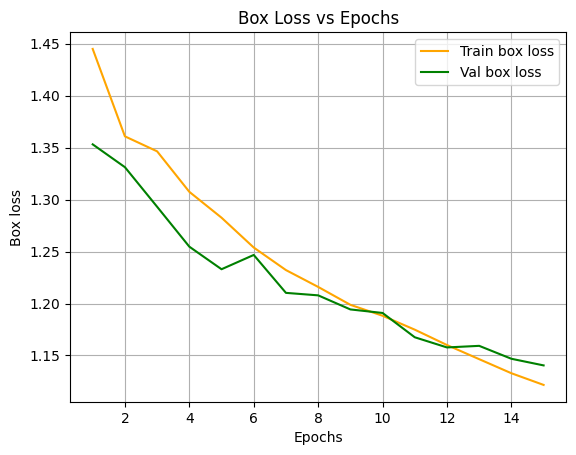

In [18]:
plt.plot(range(1, len(results_csv)+1), results_csv["train/box_loss"], color="orange", label="Train box loss")
plt.plot(range(1, len(results_csv)+1), results_csv["val/box_loss"], color="green", label="Val box loss")
plt.xlabel("Epochs")
plt.ylabel("Box loss")
plt.title("Box Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

Precision and Recall

In [20]:
import pandas as pd

# Load the results.csv
results_csv = pd.read_csv("/content/runs/detect/face_yolov8n_quick_train2/results.csv")

# Show all column names
print(results_csv.columns)

Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


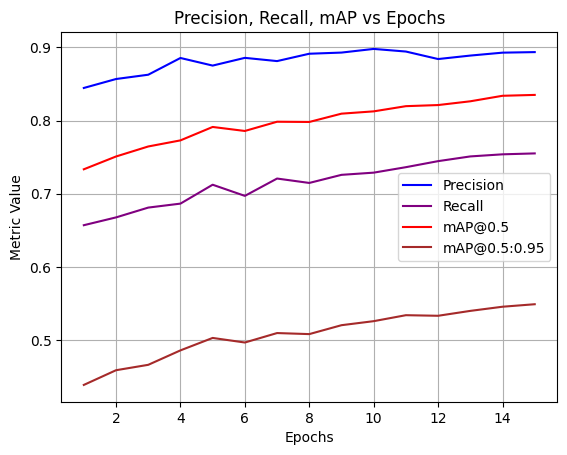

In [21]:
import matplotlib.pyplot as plt

# Plot Precision, Recall, mAP50, mAP50-95
plt.plot(results_csv["epoch"], results_csv["metrics/precision(B)"], label="Precision", color="blue")
plt.plot(results_csv["epoch"], results_csv["metrics/recall(B)"], label="Recall", color="purple")
plt.plot(results_csv["epoch"], results_csv["metrics/mAP50(B)"], label="mAP@0.5", color="red")
plt.plot(results_csv["epoch"], results_csv["metrics/mAP50-95(B)"], label="mAP@0.5:0.95", color="brown")
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.title("Precision, Recall, mAP vs Epochs")
plt.legend()
plt.grid(True)
plt.show()


Saving the Model

In [22]:
import shutil

src_path = "runs/detect/face_yolov8n_quick_train2/weights/best.pt"

dst_path = "/content/drive/MyDrive/Dhanya/Data/Data/face_yolov8n_best.pt"

# Copies the model file to Drive
shutil.copy(src_path, dst_path)

print(f"Model saved to: {dst_path}")


Model saved to: /content/drive/MyDrive/Dhanya/Data/Data/face_yolov8n_best.pt


Testing with image

In [23]:
from ultralytics import YOLO

model = YOLO("runs/detect/face_yolov8n_quick_train2/weights/best.pt")
img_path = "/content/drive/MyDrive/Dhanya/Data/Data/images/val/000cc0cd61c6c8d7.jpg"

results = model.predict(img_path, conf=0.25, save=True)




image 1/1 /content/drive/MyDrive/Dhanya/Data/Data/images/val/000cc0cd61c6c8d7.jpg: 416x288 1 face, 135.0ms
Speed: 4.5ms preprocess, 135.0ms inference, 540.4ms postprocess per image at shape (1, 3, 416, 288)
Results saved to runs/detect/predict



image 1/1 /content/drive/MyDrive/Dhanya/Data/Data/images/val/0bf4e98791c419b2.jpg: 320x416 4 faces, 38.4ms
Speed: 2.3ms preprocess, 38.4ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 416)


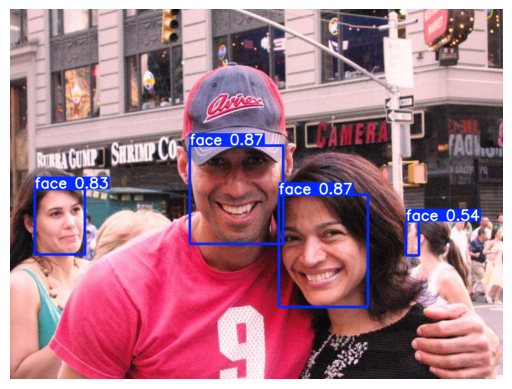

Predicted image saved to: /content/drive/MyDrive/Dhanya/Data/predicted_output.jpg


In [30]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

model = YOLO("runs/detect/face_yolov8n_quick_train2/weights/best.pt")
img_path = "/content/drive/MyDrive/Dhanya/Data/Data/images/val/0bf4e98791c419b2.jpg"


results = model.predict(img_path, conf=0.25, save=False)
pred_img = results[0].plot()
pred_img_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(pred_img_rgb)
plt.axis('off')
plt.show()

# Saves the imageto drive
save_path = "/content/drive/MyDrive/Dhanya/Data/predicted_output.jpg"
cv2.imwrite(save_path, pred_img)
print(f"Predicted image saved to: {save_path}")


In [28]:
metrics = model.val(data="/content/drive/MyDrive/Dhanya/Data/data.yaml", imgsz=416, batch=32)
print(metrics)

Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 82.3±44.6 MB/s, size: 227.4 KB)


val: Scanning /content/drive/MyDrive/Dhanya/Data/Data/labels/val.cache... 3347 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3347/3347 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 105/105 [01:12<00:00,  1.44it/s]


                   all       3347      10299      0.893      0.755      0.835      0.549
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val3
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e2845425610>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.03303